In [38]:
import numpy as np
import matplotlib.pyplot as plt
# from lgca import get_lgca
from itertools import product
import pickle as pkl
from numba import jit, prange
from matplotlib.lines import Line2D
from goorgrow.fig2 import label_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product
import pickle as pkl

PATH = '.\\data\\gog\\nonlocaldensity_10reps\\'
parameters = np.load(PATH+'params.npz', allow_pickle=True)

constparams = parameters['constparams'].item()
r_ds = parameters['r_ds']
thetas = parameters['thetas']
reps = 10
# data = np.load(PATH+'n_pr.npy', allow_pickle=True)

In [2]:
kappas_r_t = [[[] for _ in range(len(thetas))] for _ in range(len(r_ds))]
resting_cells_r_t = np.zeros((len(r_ds), len(thetas), reps), dtype=int)
total_cells_r_t = np.zeros_like(resting_cells_r_t)
migrating_cells_r_t = np.zeros_like(resting_cells_r_t)
for index in product(np.arange(0, len(r_ds)), np.arange(0, len(thetas))):
    for i in range(reps):
        with open(PATH+'data{}.pkl'.format(index+(i, 0,)), 'rb') as f:
            d = pkl.load(f)
        kappas_r_t[index[0]][index[1]].append(list(d['kappa'][d['nodes_t'].sum()]))
        resting_cells_r_t[index[0], index[1], i] = len(d['nodes_t'][..., -1].sum())
        total_cells_r_t[index[0], index[1], i] = len(d['nodes_t'].sum())

migrating_cells_r_t = total_cells_r_t - resting_cells_r_t

In [3]:
resting_fraction_r_t = resting_cells_r_t / total_cells_r_t
migration_fraction_r_t = migrating_cells_r_t / total_cells_r_t

In [4]:
phenotype_entropy = - resting_fraction_r_t * np.log2(resting_fraction_r_t) - migration_fraction_r_t * np.log2(migration_fraction_r_t)
mean_phenotype_entropy = phenotype_entropy.mean(axis=-1)

In [5]:
dtheta = (thetas[1] - thetas[0]) / 2
dr_ds = (r_ds[1] - r_ds[0]) / 2
extent = [thetas[0]-dtheta, thetas[-1]+dtheta, r_ds[0]-dr_ds, r_ds[-1]+dr_ds]

In [39]:
bbox_attr = dict(boxstyle='circle,pad=0.2', edgecolor='black', facecolor='white', linewidth=1)
plt.imshow(mean_phenotype_entropy, aspect='equal', vmin=0, vmax=1, extent=extent, origin='lower')
plt.colorbar(label=r'Entropy', pad=0.2, fraction=0.05, orientation='horizontal', ticks=[0, 1])
plt.xlabel(r'Switch threshold $\theta$')
plt.ylabel(r'Death rate $\delta$')
plt.text(0.2, 0., '1', fontsize=8, weight='bold',
        ha='center',
        va='center',
        bbox=bbox_attr
         )
plt.text(0.2, 0.2, '2', fontsize=8, weight='bold',
        ha='center',
        va='center',
        bbox=bbox_attr
         )
plt.text(1., 0.2, '3', fontsize=8, weight='bold', bbox=bbox_attr,
        ha='center',
        va='center',
         )
contour = plt.contour(thetas, r_ds, 1 - np.array(r_ds)[:, np.newaxis] - np.array(thetas)[np.newaxis, :], levels=[0], colors='k', linestyles='dashed', extent=extent, origin='lower')
plt.title('Phenotypic entropy')
plt.show()

In [7]:
def estimate_entropy(data):
    # Compute histogram of data using numpy's automatic bin selection
    hist, bin_edges = np.histogram(data, bins='auto', density=True)

    # Calculate bin widths
    bin_width = bin_edges[1] - bin_edges[0]
    print(hist.sum() * bin_width)

    # Create a masked array to handle zero probabilities
    probabilities = np.ma.masked_equal(hist, 0)

    # Compute the entropy
    entropy = -np.ma.sum(probabilities * np.ma.log2(probabilities) * bin_width)

    return entropy

In [51]:
@jit(nopython=True, parallel=True, fastmath=True, nogil=True)
def raos_quadratic_entropy(kappa):
    rqe = 0.
    N = len(kappa)
    for i in prange(N-1):
        for j in prange(i+1, N):
            rqe += abs(kappa[i] - kappa[j])
    rqe /= N**2
    return rqe

In [9]:
genetic_entropy = [[[[estimate_entropy(kappas_r_t[i][j][k])] for k in range(reps)] for j in range(len(thetas))] for i in range(len(r_ds))]

0.9999999999999928
1.0000000000000033
1.000000000000004
1.000000000000004
1.0000000000000007
1.0000000000000038
1.0000000000000067
1.0000000000000002
0.9999999999999949
0.9999999999999978
1.000000000000003
0.9999999999999961
1.000000000000006
0.9999999999999949
0.9999999999999971
1.0000000000000022
0.9999999999999959
0.9999999999999937
1.0000000000000044
1.0000000000000013
1.0000000000000047
1.0000000000000013
0.999999999999998
1.0000000000000016
1.000000000000008
1.000000000000002
0.9999999999999962
0.9999999999999983
1.0000000000000004
1.000000000000002
0.999999999999997
1.0000000000000004
1.0000000000000073
0.9999999999999969
1.0000000000000027
0.9999999999999987
1.0000000000000018
1.0000000000000047
0.9999999999999937
1.0000000000000047
0.9999999999999958
1.0000000000000009
0.999999999999998
1.000000000000005
1.000000000000004
1.0000000000000033
0.9999999999999973
1.000000000000002
1.0000000000000009
0.9999999999999978
1.0000000000000042
1.000000000000005
0.9999999999999933
1.00000

In [49]:
quadratic_entropy = [[[[raos_quadratic_entropy(kappas_r_t[i][j][k])] for k in range(reps)] for j in range(len(thetas))] for i in range(len(r_ds))]

C:\ProgramData\anaconda3\envs\py311\Lib\site-packages\numba\core\ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'kappa' of function 'raos_quadratic_entropy'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\AppData\Local\Temp\ipykernel_16316\2789773721.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\ProgramData\anaconda3\envs\py311\Lib\site-packages\numba\core\ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'kappa' of function '__numba_parfor_gufunc_0x1603c4f97d0'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-

(array([   9.,   31.,   57.,  101.,  171.,  176.,  210.,  303.,  392.,
         471.,  549.,  665.,  712.,  835.,  902., 1055., 1080., 1201.,
        1096., 1171., 1179., 1202., 1310., 1317., 1353., 1385., 1359.,
        1309., 1296., 1343., 1385., 1243., 1140., 1188., 1226., 1245.,
        1126., 1105., 1278., 1288., 1300., 1293., 1257., 1157.,  827.,
         762.,  679.,  639.,  594.,  528.,  388.,  160.,   78.,    7.]),
 array([-19.56058128, -19.17939922, -18.79821717, -18.41703512,
        -18.03585307, -17.65467102, -17.27348896, -16.89230691,
        -16.51112486, -16.12994281, -15.74876076, -15.36757871,
        -14.98639665, -14.6052146 , -14.22403255, -13.8428505 ,
        -13.46166845, -13.08048639, -12.69930434, -12.31812229,
        -11.93694024, -11.55575819, -11.17457614, -10.79339408,
        -10.41221203, -10.03102998,  -9.64984793,  -9.26866588,
         -8.88748383,  -8.50630177,  -8.12511972,  -7.74393767,
         -7.36275562,  -6.98157357,  -6.60039151,  -6.219209

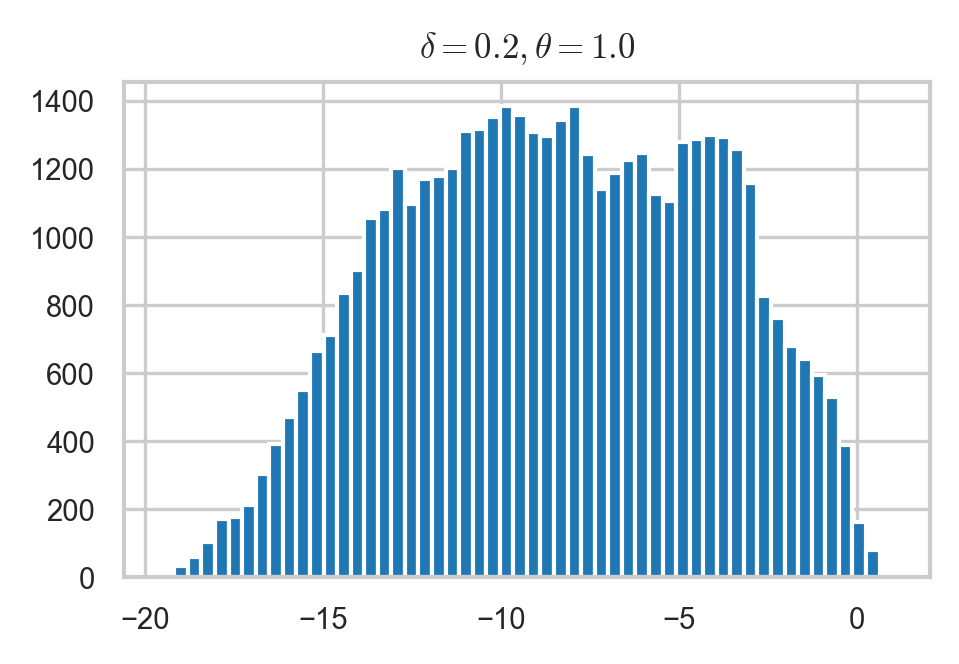

In [11]:
index = -2, -1, 0
plt.title(r'$\delta = {}, \theta = {}$'.format(r_ds[index[0]], thetas[index[1]]))
plt.hist(kappas_r_t[-2][-1][0])

In [50]:
quadratic_entropy = np.array(quadratic_entropy).mean(-1)
mean_quadratic_entropy = quadratic_entropy.mean(axis=-1)

In [13]:
genetic_entropy = np.array(genetic_entropy).mean(-1)
mean_genetic_entropy = genetic_entropy.mean(axis=-1)

In [42]:
plt.style.use('default')
plt.style.use('nature_style.mplstyle')

In [43]:
plt.imshow(mean_genetic_entropy, aspect='equal', extent=extent, origin='lower', vmin=1, vmax=4, cmap='viridis')
plt.colorbar(label=r'Entropy', pad=0.2, fraction=0.05, orientation='horizontal', ticks=[1, 4])
plt.xlabel(r'Switch threshold $\theta$')
plt.ylabel(r'Death rate $\delta$')
plt.text(0.2, 0., '1', fontsize=8, weight='bold',
        ha='center',
        va='center',
        bbox=bbox_attr
         )
plt.text(0.2, 0.2, '2', fontsize=8, weight='bold',
        ha='center',
        va='center',
        bbox=bbox_attr
         )
plt.text(1., 0.2, '3', fontsize=8, weight='bold', bbox=bbox_attr,
        ha='center',
        va='center',
         )
contour = plt.contour(thetas, r_ds, 1 - np.array(r_ds)[:, np.newaxis] - np.array(thetas)[np.newaxis, :], levels=[0], colors='k', linestyles='dashed', extent=extent, origin='lower')
plt.title('Genetic entropy')
plt.show()

In [15]:
# plt.imshow(mean_quadratic_entropy, aspect='equal', extent=extent, origin='lower', cmap='viridis')
# plt.colorbar(label=r'Quadratic entropy', pad=0.2, fraction=0.05, orientation='horizontal')
# plt.xlabel(r'Switch threshold $\theta$')
# plt.ylabel(r'Death rate $\delta$')
# plt.text(0.2, 0., '1', fontsize=8, weight='bold',
#         ha='center',
#         va='center',
#         bbox=bbox_attr
#          )
# plt.text(0.2, 0.2, '2', fontsize=8, weight='bold',
#         ha='center',
#         va='center',
#         bbox=bbox_attr
#          )
# plt.text(1., 0.2, '3', fontsize=8, weight='bold', bbox=bbox_attr,
#         ha='center',
#         va='center',
#          )
# contour = plt.contour(thetas, r_ds, 1 - np.array(r_ds)[:, np.newaxis] - np.array(thetas)[np.newaxis, :], levels=[0], colors='k', linestyles='dashed', extent=extent, origin='lower')
# plt.title('Quadratic entropy')
# plt.show()

In [16]:
# from scipy.stats import skew, kurtosis
# from sklearn.mixture import GaussianMixture

In [17]:
# calculate bimodality coefficent
# calculate skewness
# def bc(x):
#     sk = skew(x)
#     k = kurtosis(x, fisher=False)
#     n = len(x)
#     return (sk**2 + 1) / (k + 3 * ((n - 1)**2 / ((n - 2) * (n - 3))))

In [18]:
# def aic_diff(x):
#     f1 = GaussianMixture(n_components=1).fit(x[:, np.newaxis])
#     f2 = GaussianMixture(n_components=2).fit(x[:, np.newaxis])
#     aic1 = f1.aic(x[:, np.newaxis])
#     aic2 = f2.aic(x[:, np.newaxis])
#     return (aic1 - aic2) / max(aic1, aic2)

In [19]:
# kurt = np.array([[kurtosis(np.array(kappas_r_t[i][j]), fisher=False, bias=False) for j in range(len(thetas))] for i in range(len(r_ds))])

In [20]:
# bcs = np.array([[bc(np.array(kappas_r_t[i][j])) for j in range(len(thetas))] for i in range(len(r_ds))])

In [21]:
# aic = np.array([[aic_diff(np.array(kappas_r_t[i][j])) for j in range(len(thetas))] for i in range(len(r_ds))])

In [22]:
# med = np.array([[np.median(np.array(kappas_r_t[i][j])) for j in range(len(thetas))] for i in range(len(r_ds))])
kappas_r_t_temp = [[[] for j in range(len(thetas))] for i in range(len(r_ds))]
for i in range(len(r_ds)):
    for j in range(len(thetas)):
        for k in range(reps):
            kappas_r_t_temp[i][j].extend(kappas_r_t[i][j][k])
meankappa = np.array([[np.mean(np.array(kappas_r_t_temp[i][j])) for j in range(len(thetas))] for i in range(len(r_ds))])

In [23]:
# skewness = np.array([[skew(np.array(kappas_r_t[i][j]), bias=False) for j in range(len(thetas))] for i in range(len(r_ds))])

In [24]:
# plt.imshow(skewness, cmap='coolwarm', aspect='equal', vmax=2, vmin=-2)
# plt.colorbar()
# plt.show()

In [25]:
# plt.imshow(pvals, cmap='gray', aspect='equal')
# plt.colorbar()

In [26]:
# plt.imshow(bcs, cmap='gray', aspect='equal')
# plt.colorbar()

In [27]:
# plt.imshow(aic, cmap='coolwarm', aspect='equal')
# plt.colorbar()

In [28]:
# plt.imshow(aic> 0, cmap='gray', aspect='equal')
# plt.colorbar()

In [29]:
# # Create a figure using the style
# fig, ax = plt.subplots()
# # Get the current figure size
# fig_width, fig_height = fig.get_size_inches()
#
# bbox_attr = dict(boxstyle='circle,pad=0.2', edgecolor='black', facecolor='white', linewidth=1)
#
# # Set the new figure size by multiplying it by the scale factor
# scale_factor = 0.7
# fig.set_size_inches(fig_width * scale_factor, fig_height)
# plt.imshow(med, cmap='coolwarm', aspect='equal', extent=extent, vmin=-5, vmax=5, interpolation='none', origin='lower')
# # place colorbar at bottom of image
# plt.colorbar(label=r'Switch parameter ${\kappa}$', pad=0.2, fraction=0.05, orientation='horizontal')
# plt.xlabel(r'Switch threshold $\theta$')
# plt.ylabel(r'Death rate $\delta$')
# plt.text(0.2, 0., '1', fontsize=8, weight='bold',
#         ha='center',
#         va='center',
#         bbox=bbox_attr
#          )
# plt.text(0.2, 0.2, '2', fontsize=8, weight='bold',
#         ha='center',
#         va='center',
#         bbox=bbox_attr
#          )
# plt.text(1., 0.2, '3', fontsize=8, weight='bold', bbox=bbox_attr,
#         ha='center',
#         va='center',
#          )
# contour = plt.contour(thetas, r_ds, 1 - np.array(r_ds)[:, np.newaxis] - np.array(thetas)[np.newaxis, :], levels=[0], colors='k', linestyles='dashed', extent=extent, origin='lower')
# # custom_line = Line2D([0], [0], color='k', linestyle='dashed', label=r'$\rho_{\mathcal{N}}^{\max} - \theta = 0$')
# custom_line = Line2D([0], [0], color='k', linestyle='dashed', label='Prediction')
# plt.legend(handles=[custom_line], loc='lower right', bbox_to_anchor=(1, 1))
# # plt.savefig('evolutionary_regimes.svg', bbox_inches='tight')
# # plt.savefig('evolutionary_regimes.pdf', bbox_inches='tight')

In [44]:
# Create a figure using the style
fig, ax = plt.subplots()
# Get the current figure size
fig_width, fig_height = fig.get_size_inches()

bbox_attr = dict(boxstyle='circle,pad=0.2', edgecolor='black', facecolor='white', linewidth=1)

# Set the new figure size by multiplying it by the scale factor
scale_factor = 0.7
fig.set_size_inches(fig_width * scale_factor, fig_height)
plt.imshow(meankappa, cmap='coolwarm', aspect='equal', extent=extent, vmin=-5, vmax=5, interpolation='none', origin='lower')
# place colorbar at bottom of image
plt.colorbar(label=r'Switch parameter ${\kappa}$', pad=0.2, fraction=0.05, orientation='horizontal')
plt.xlabel(r'Switch threshold $\theta$')
plt.ylabel(r'Death rate $\delta$')
plt.text(0.2, 0., '1', fontsize=8, weight='bold',
        ha='center',
        va='center',
        bbox=bbox_attr
         )
plt.text(0.2, 0.2, '2', fontsize=8, weight='bold',
        ha='center',
        va='center',
        bbox=bbox_attr
         )
plt.text(1., 0.2, '3', fontsize=8, weight='bold', bbox=bbox_attr,
        ha='center',
        va='center',
         )
contour = plt.contour(thetas, r_ds, 1 - np.array(r_ds)[:, np.newaxis] - np.array(thetas)[np.newaxis, :], levels=[0], colors='k', linestyles='dashed', extent=extent, origin='lower')
# custom_line = Line2D([0], [0], color='k', linestyle='dashed', label=r'$\rho_{\mathcal{N}}^{\max} - \theta = 0$')
custom_line = Line2D([0], [0], color='k', linestyle='dashed', label='Prediction')
plt.legend(handles=[custom_line], loc='lower right', bbox_to_anchor=(1, 1))
# plt.savefig('evolutionary_regimes.svg', bbox_inches='tight')
# plt.savefig('evolutionary_regimes.pdf', bbox_inches='tight')

In [31]:


PATH = '.\\data\\gog\\nonlocaldensity_10reps\\'
parameters = np.load(PATH + 'params.npz', allow_pickle=True)
PATH = '.\\data\\gog\\nonlocaldensity_recurrence\\'
constparams = parameters['constparams'].item()
r_ds = parameters['r_ds']
thetas = parameters['thetas']
reps = 10
dtheta = (thetas[1] - thetas[0]) / 2
dr_ds = (r_ds[1] - r_ds[0]) / 2
rec_time = np.zeros((len(r_ds), len(thetas), reps), dtype=int)
rec_time = np.ma.array(rec_time, mask=True)
for index in product(np.arange(0, len(r_ds)), np.arange(0, len(thetas))):
    for i in range(reps):
        with open(PATH + 'data{}.pkl'.format(index + (i, 0,)), 'rb') as f:
            d = pkl.load(f)
        rec_time[index + (i,)] = d['tmax']
        rec_time.mask[index + (i,)] = False if d['n_it'] > 0 else True

In [36]:
%matplotlib qt

In [53]:
# create a figure with 4 subplots
# figsize = 7.086614, 8.858268 / 4
figsize = 7, 2.5
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=figsize)
# Get the current figure size
# fig_width, fig_height = fig.get_size_inches()
# # fig_height *= 1.5
# fig.set_size_inches(fig_width, fig_height)

plt.sca(ax[0, 0])
# plt.xlabel(r'Switch threshold $\theta$')
# plt.ylabel(r'Death rate $\delta$')
plt.imshow(meankappa, cmap='coolwarm', aspect='equal', extent=extent, vmin=-5, vmax=5, interpolation='none', origin='lower')
# insert color bar to the right of image with the same height
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(label=r'Switch ${\kappa}$', pad=0.2, fraction=0.05, use_gridspec=True, cax=cax)
# plt.colorbar(label=r'Switch parameter ${\kappa}$', pad=0.2, fraction=0.05, orientation='vertical')
# plt.xlabel(r'Switch threshold $\theta$')
# plt.ylabel(r'Death rate $\delta$')
plt.sca(ax[0, 0])

plt.text(0.2, 0., '1', fontsize=8, weight='bold',
        ha='center',
        va='center',
        bbox=bbox_attr
         )
plt.text(0.2, 0.2, '2', fontsize=8, weight='bold',
        ha='center',
        va='center',
        bbox=bbox_attr
         )
plt.text(1., 0.2, '3', fontsize=8, weight='bold', bbox=bbox_attr,
        ha='center',
        va='center',
         )
contour = plt.contour(thetas, r_ds, 1 - np.array(r_ds)[:, np.newaxis] - np.array(thetas)[np.newaxis, :], levels=[0], colors='k', linestyles='dashed', extent=extent, origin='lower')
# custom_line = Line2D([0], [0], color='k', linestyle='dashed', label=r'$\rho_{\mathcal{N}}^{\max} - \theta = 0$')
# custom_line = Line2D([0], [0], color='k', linestyle='dashed', label='Prediction')
# plt.legend(handles=[custom_line], loc='lower right', bbox_to_anchor=(1, 1))
plt.title('Average switch')

plt.sca(ax[0, 1])
plt.imshow(mean_phenotype_entropy, aspect='equal', vmin=0, vmax=1, extent=extent, origin='lower')
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(label=r'Entropy', pad=0.2, fraction=0.05, orientation='vertical', ticks=[0, 1], cax=cax, use_gridspec=True)
plt.sca(ax[0, 1])
plt.text(0.2, 0., '1', fontsize=8, weight='bold',
        ha='center',
        va='center',
        bbox=bbox_attr
         )
plt.text(0.2, 0.2, '2', fontsize=8, weight='bold',
        ha='center',
        va='center',
        bbox=bbox_attr
         )
plt.text(1., 0.2, '3', fontsize=8, weight='bold', bbox=bbox_attr,
        ha='center',
        va='center',
         )
contour = plt.contour(thetas, r_ds, 1 - np.array(r_ds)[:, np.newaxis] - np.array(thetas)[np.newaxis, :], levels=[0], colors='k', linestyles='dashed', extent=extent, origin='lower')
plt.title('Phenotypic entropy')

plt.sca(ax[1, 0])
plt.imshow(mean_genetic_entropy, aspect='equal', extent=extent, origin='lower', vmin=1, vmax=4)
divider = make_axes_locatable(ax[1, 0])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(label=r'Entropy', pad=0.2, fraction=0.05, ticks=[1, 4], cax=cax, use_gridspec=True)
plt.sca(ax[1, 0])
plt.text(0.2, 0., '1', fontsize=8, weight='bold',
        ha='center',
        va='center',
        bbox=bbox_attr
         )
plt.text(0.2, 0.2, '2', fontsize=8, weight='bold',
        ha='center',
        va='center',
        bbox=bbox_attr
         )
plt.text(1., 0.2, '3', fontsize=8, weight='bold', bbox=bbox_attr,
        ha='center',
        va='center',
         )
contour = plt.contour(thetas, r_ds, 1 - np.array(r_ds)[:, np.newaxis] - np.array(thetas)[np.newaxis, :], levels=[0], colors='k', linestyles='dashed', extent=extent, origin='lower')
plt.title('Genetic entropy')
# plt.ylabel(r'Death rate $\delta$')

plt.sca(ax[-1, -1])
plt.imshow(rec_time.mean(-1), aspect='equal', extent=extent, origin='lower', )
plt.text(0.2, 0., '1', fontsize=8, weight='bold',
        ha='center',
        va='center',
        bbox=bbox_attr
         )
plt.text(0.2, 0.2, '2', fontsize=8, weight='bold',
        ha='center',
        va='center',
        bbox=bbox_attr
         )
plt.text(1., 0.2, '3', fontsize=8, weight='bold', bbox=bbox_attr,
        ha='center',
        va='center',
         )
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(label=r'Recurrence time', pad=0.2, fraction=0.05, orientation='vertical', use_gridspec=True, cax=cax)
plt.sca(ax[-1, -1])
contour = plt.contour(thetas, r_ds, 1 - np.array(r_ds)[:, np.newaxis] - np.array(thetas)[np.newaxis, :], levels=[0], colors='k', linestyles='dashed', extent=extent, origin='lower')
plt.ylim(-dr_ds, r_ds[-1]+dr_ds)
plt.title('Recurrence time')
plt.xticks([0, 0.5, 1])
fig.supxlabel(r'Switch threshold $\theta$')
fig.supylabel(r'Death rate $\delta$')
label_axes(fig, labels=['A', 'B', 'C', 'D', '', '', '', ''])
fig.tight_layout()
plt.savefig('heterogeneity_treatment.pdf', bbox_inches='tight')
plt.savefig('heterogeneity_treatment.svg', bbox_inches='tight')

# Save everthing as a dataframe

In [ ]:
import pandas as pd

In [ ]:
kappas_r_t_df = np.zeros((len(r_ds), len(thetas), reps))
for i in range(len(r_ds)):
    for j in range(len(thetas)):
        for k in range(reps):
            kappas_r_t_df[i, j, k] = np.mean(kappas_r_t[i][j][k])

In [ ]:
# kappas_r_t, genetic_entropy, phenotype_entropy, rec_time, r_ds, thetas

In [ ]:
x, y, z = kappas_r_t_df.shape

In [ ]:
combinations = x * y
total_repetitions = combinations * z

In [ ]:
expanded_r_ds = np.repeat(r_ds, y).repeat(z)
expanded_thetas = np.tile(thetas, x).repeat(z)


In [ ]:
params_df = pd.DataFrame({
    'r_d': expanded_r_ds,
    'theta': expanded_thetas,
    'repetition': np.tile(np.arange(z), combinations)
}, index=np.arange(total_repetitions))

In [ ]:
kappas_flat = kappas_r_t_df.flatten()
genetic_entropy_flat = genetic_entropy.flatten()
phenotype_entropy_flat = phenotype_entropy.flatten()
rectime_flat = rec_time.flatten()

kappas_df = pd.DataFrame({'kappa': kappas_flat}, index=np.arange(total_repetitions))
genetic_entropy_df = pd.DataFrame({'genetic_entropy': genetic_entropy_flat}, index=np.arange(total_repetitions))
phenotype_entropy_df = pd.DataFrame({'phenotype_entropy': phenotype_entropy_flat}, index=np.arange(total_repetitions))
rectime_df = pd.DataFrame({'rectime': rectime_flat}, index=np.arange(total_repetitions))

In [ ]:
df = pd.concat([params_df, kappas_df, genetic_entropy_df, phenotype_entropy_df, rectime_df], axis=1)

In [ ]:
df.head()

In [ ]:
# df.to_csv('treatment.csv', index=False)  # save df to csv